# PyMC model

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy import stats
from scipy.special import expit as logistic

In [4]:
from pyBasket.common import load_obj

## Load data

Load previously generated data + clustering information (stored in an Analysis object).

In [5]:
# analysis_name = 'clustering'
# stage = 1

# analysis = load_obj('%s_%d.p' % (analysis_name, stage))
# analysis

In [6]:
# cd = analysis.clustering_data
# cd.responses.shape, cd.classes.shape, cd.features.shape, cd.clusters.shape

In [7]:
# df = cd.to_df()
# df.head()

In [8]:
# df.shape

In [9]:
# classes = df['class'].unique()
# classes

In [10]:
# ns = []
# ks = []
# for cls in classes:
#     observed = df[df['class'] == cls]['response'].values
#     n = len(observed)
#     k = np.sum(observed)
#     ns.append(n)
#     ks.append(k)
#     print(cls, observed, n, k)
    
# ns = np.array(ns)
# ks = np.array(ks)
# ns, ks

## Generate some data

In [11]:
# true params
α_true = [0.75, 0.25, 0.0, -0.25, -0.5]
β_true = np.array([1, 0, -1])

data = np.array([
    [0.75, 0.00, 0.00],
    [0.25, 0.25, 0.00],
    [0.00, 0.50, 0.00],
    [0.00, 0.25, 0.25],
    [0.00, 0.00, 0.75]
])

# Linear model
s_k0 = data[:, 0]
s_k1 = data[:, 1]
s_k2 = data[:, 2]
p_true = α_true + (β_true[0] * s_k0) + (β_true[1] * s_k1) + (β_true[2] * s_k2)
θ_true = logistic(p_true)

# Sample data
n = 20
n_success = np.random.binomial(n=n, p=θ_true)
n_trial = np.array([n] * len(n_success))

# Bundle data into dataframe
data = pd.DataFrame({'s_k0': s_k0, 's_k1': s_k1, 's_k2': s_k2, 'n_success': n_success, 'n_trial': n_trial})

In [12]:
n_success, n_trial, p_true, θ_true

(array([19, 14, 11,  5,  3]),
 array([20, 20, 20, 20, 20]),
 array([ 1.5 ,  0.5 ,  0.  , -0.5 , -1.25]),
 array([0.81757448, 0.62245933, 0.5       , 0.37754067, 0.22270014]))

In [13]:
data

,s_k0,s_k1,s_k2,n_success,n_trial
0,0.75,0.00,0.00,19,20
1,0.25,0.25,0.00,14,20
2,0.00,0.50,0.00,11,20
3,0.00,0.25,0.25,5,20
4,0.00,0.00,0.75,3,20


## Plot underlying linear model

In [14]:
# fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
# ax[0].plot(x, mu_true, label=r"$β_0 + β_1 \cdot x_i$")
# ax[0].set(xlabel="$x$", ylabel=r"$β_0 + β_1 \cdot x_i$", title="Underlying linear model")
# ax[0].legend()

# # Plot GLM
# freq = ax[1].twinx()  # instantiate a second axes that shares the same x-axis
# freq.set_ylabel("number of successes")
# freq.scatter(x, y, color="k")
# # plot proportion related stuff on ax[1]
# ax[1].plot(x, p_true, label=r"$g^{-1}(β_0 + β_1 \cdot x_i)$")
# ax[1].set_ylabel("proportion successes", color="b")
# ax[1].tick_params(axis="y", labelcolor="b")
# ax[1].set(xlabel="$x$", title="Binomial regression")
# ax[1].legend()

# # get y-axes to line up
# y_buffer = 1
# freq.set(ylim=[-y_buffer, n + y_buffer])
# ax[1].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
# freq.grid(None)

## Define models

No. of samples to collect before and after burn-in during MCMC.

In [15]:
n_burn_in = int(1E4)
n_sample = int(1E4)

### Simple hierarchical model

This is the standard simple hierarchical model typically used to infer basket success rate given the observed number of successes. It doesn't take into consideration the clustering information used to generate the data.

In [16]:
K = len(data)
ns = data['n_trial'].values
ks = data['n_success'].values

with pm.Model() as model_simple:
    α = pm.Gamma('alpha', alpha=2, beta=0.5)
    β = pm.Gamma('beta', alpha=2, beta=0.5)

    θ = pm.Beta('theta', alpha=α, beta=β, shape=K)
    y = pm.Binomial('y', n=ns, p=θ, observed=ks)

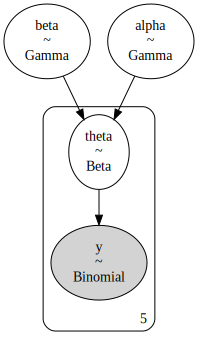

In [17]:
pm.model_to_graphviz(model_simple)

In [18]:
with model_simple:
    trace_simple = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 40 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


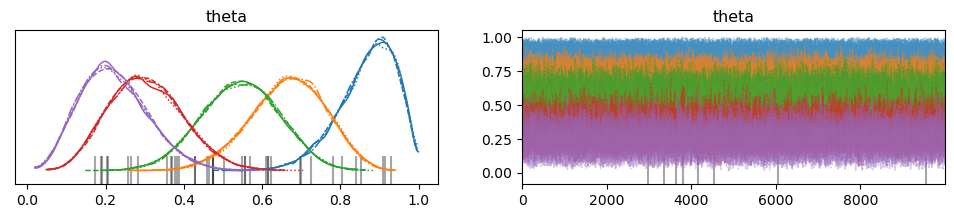

In [19]:
az.plot_trace(trace_simple, var_names=['theta']);

In [20]:
stacked_simple = az.extract(trace_simple)

array([0.86840741, 0.66631017, 0.54468124, 0.30307234, 0.22181317])

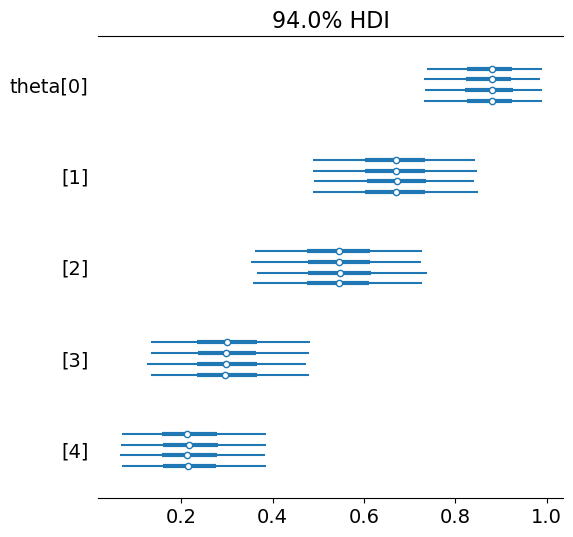

In [21]:
az.plot_forest(trace_simple, var_names='theta')
np.mean(stacked_simple.theta.values, axis=1)

In [22]:
np.mean(stacked_simple.alpha.values, axis=0)

2.597185636922087

In [23]:
np.mean(stacked_simple.beta.values, axis=0)

2.344309242519687

### Logistic regression model

This is a simpler logistic regression model to predict response rate given the proportions of cluster members found in each basket.
Unlike the hierarchical model below, there's only one α which is shared by all baskets. The parameters of the α, β_0 and β_1 distributions are also fixed.

In [24]:
with pm.Model() as model_logreg:
    
    # Extract data from dataframe
    K = data.shape[0]
    C = data.shape[1] - 2    
    s_k = pm.ConstantData('s_k', data.values[:, 0:C])
            
    # priors
    α = pm.Normal('alpha', mu=0, sigma=10, shape=K)    
    β = pm.Normal('beta', mu=0, sigma=10, shape=C)
    
    # linear model
    p = pm.math.dot(s_k, β) + α
    θ = pm.Deterministic('theta', pm.math.invlogit(p))
    
    # likelihood
    pm.Binomial('y', n=n, p=θ, observed=data['n_success'], shape=K)

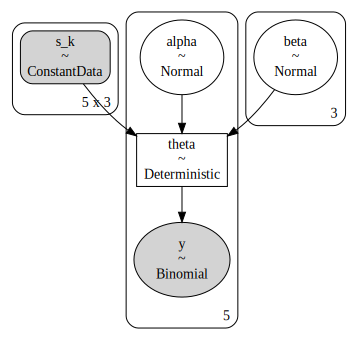

In [25]:
pm.model_to_graphviz(model_logreg)

In [26]:
with model_logreg:
    trace_logreg = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 101 seconds.
The acceptance probability does not match the target. It is 0.6409, but should be close to 0.8. Try to increase the number of tuning steps.


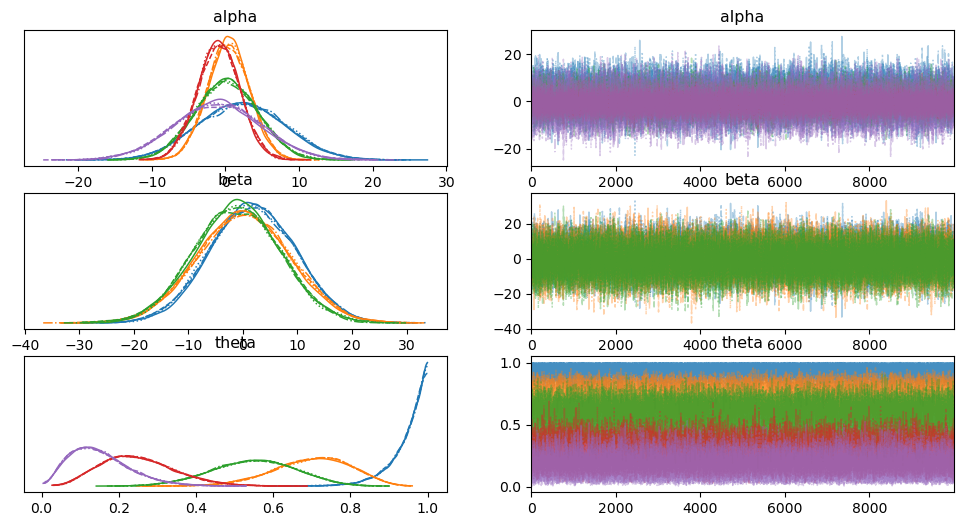

In [27]:
az.plot_trace(trace_logreg, var_names=['alpha', 'beta', 'theta']);

In [28]:
stacked_logreg = az.extract(trace_logreg)

array([0.94871789, 0.70007137, 0.55024844, 0.24975117, 0.15096236])

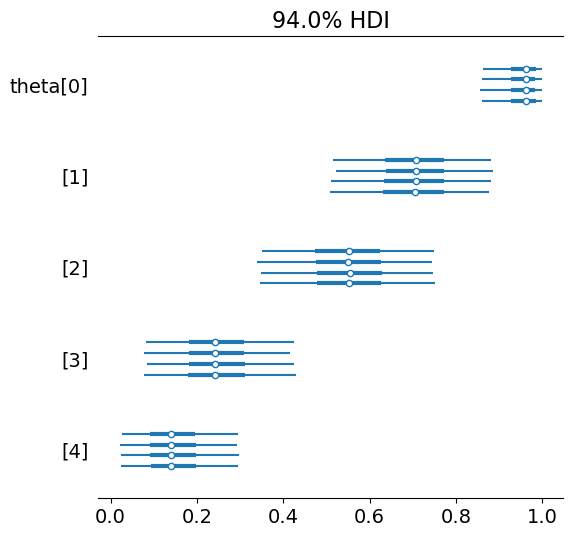

In [29]:
az.plot_forest(trace_logreg, var_names='theta')
np.mean(stacked_logreg.theta.values, axis=1)

In [30]:
np.mean(stacked_logreg.alpha.values, axis=1)

array([ 2.15524374,  0.41951422,  0.12175011, -0.9357564 , -1.03467253])

In [31]:
np.mean(stacked_logreg.beta.values, axis=1)

array([ 1.72904811,  0.18032698, -1.11650929])

### Hierarchical logistic regression model

#### Centered model

This is a more complex hierarchical logistic regression model, with additional hyper-priors on the parameters. Each basket k also has its own intercept term α_k.

In [32]:
with pm.Model() as model_logreg_h:
    
    # Extract data from dataframe
    K = data.shape[0]
    C = data.shape[1] - 2    
    s_k = pm.ConstantData('s_k', data.values[:, 0:C])
    
    # hyper-priors    
    μ_α = pm.Normal('mu_alpha', mu=0, sigma=10)    
    σ_α = pm.HalfNormal('sigma_alpha', sigma=10)    
    σ_β = pm.HalfNormal('sigma_beta', sigma=10, shape=C)  
    
    # priors
    α = pm.Normal('alpha', mu=μ_α, sigma=σ_α, shape=K)    
    β = pm.Normal('beta', mu=0, sigma=σ_β, shape=C)
    
    # linear model
    p = pm.math.dot(s_k, β) + α
    θ = pm.Deterministic('theta', pm.math.invlogit(p))
    
    # likelihood
    pm.Binomial('y', n=n, p=θ, observed=data['n_success'], shape=K)

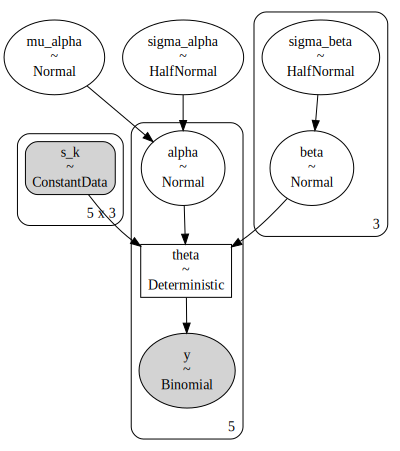

In [33]:
pm.model_to_graphviz(model_logreg_h)

In [34]:
with model_logreg_h:
    trace_logreg_h = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, sigma_beta, alpha, beta]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 926 seconds.
There were 223 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9633, but should be close to 0.99. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.


A lot of warning about divergences above.

> In the context of PyMC, divergence refers to a situation where the Markov Chain Monte Carlo (MCMC) sampling algorithm is not able to find a good approximation of the target distribution. Divergence can occur in MCMC sampling when the sampler encounters a highly correlated or multi-modal posterior distribution. This can cause the sampler to get stuck in a local mode or move slowly between different modes. PyMC3, the version of PyMC that uses the No U-Turn Sampler (NUTS) algorithm, includes a built-in divergence detection and handling mechanism. The NUTS sampler will automatically detect divergences and will print a warning message if divergences are found. Divergences can also be detected by looking at the traceplot of the sampler. If the traceplot shows a lot of divergences, it might indicate the sampler is not able to find the optimal solution.

> Dealing with divergences can be a challenging task, solutions could be:
> - Increasing the number of tuning steps or the number of samples.
> - Changing the initialization of the sampler.
> - Re-specifying the model or the priors.
> - Using a different sampling algorithm.
> - Adding more informative prior on some parameters.
> It is important to note that, just because divergences are detected, it doesn't necessarily mean that the model is wrong. It might just mean that the sampler is not able to find the optimal solution.

In [35]:
az.summary(trace_logreg_h).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,-0.37,1.93,-4.07,3.28,0.03,0.02,3157.0,5302.0,1.0
alpha[0],-0.09,2.31,-4.25,4.38,0.04,0.03,3140.0,5938.0,1.0
alpha[1],-0.35,1.78,-3.74,3.04,0.03,0.02,2932.0,4916.0,1.0
alpha[2],-0.22,2.04,-4.24,3.61,0.04,0.02,3185.0,5164.0,1.0
alpha[3],-0.69,1.71,-4.03,2.56,0.03,0.02,3242.0,5188.0,1.0
alpha[4],-0.51,2.09,-4.34,3.56,0.03,0.02,3797.0,6012.0,1.0
beta[0],4.26,3.36,-1.46,10.70,0.06,0.04,3532.0,6723.0,1.0
beta[1],0.69,4.13,-7.15,8.87,0.07,0.05,3214.0,5333.0,1.0
beta[2],-1.84,2.90,-7.62,3.28,0.04,0.03,4310.0,6354.0,1.0
sigma_alpha,1.05,1.28,0.02,3.13,0.02,0.01,2915.0,4252.0,1.0


array([[<AxesSubplot: title={'center': 'theta\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'theta\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'theta\n2'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'theta\n3'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'theta\n4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: >]], dtype=object)

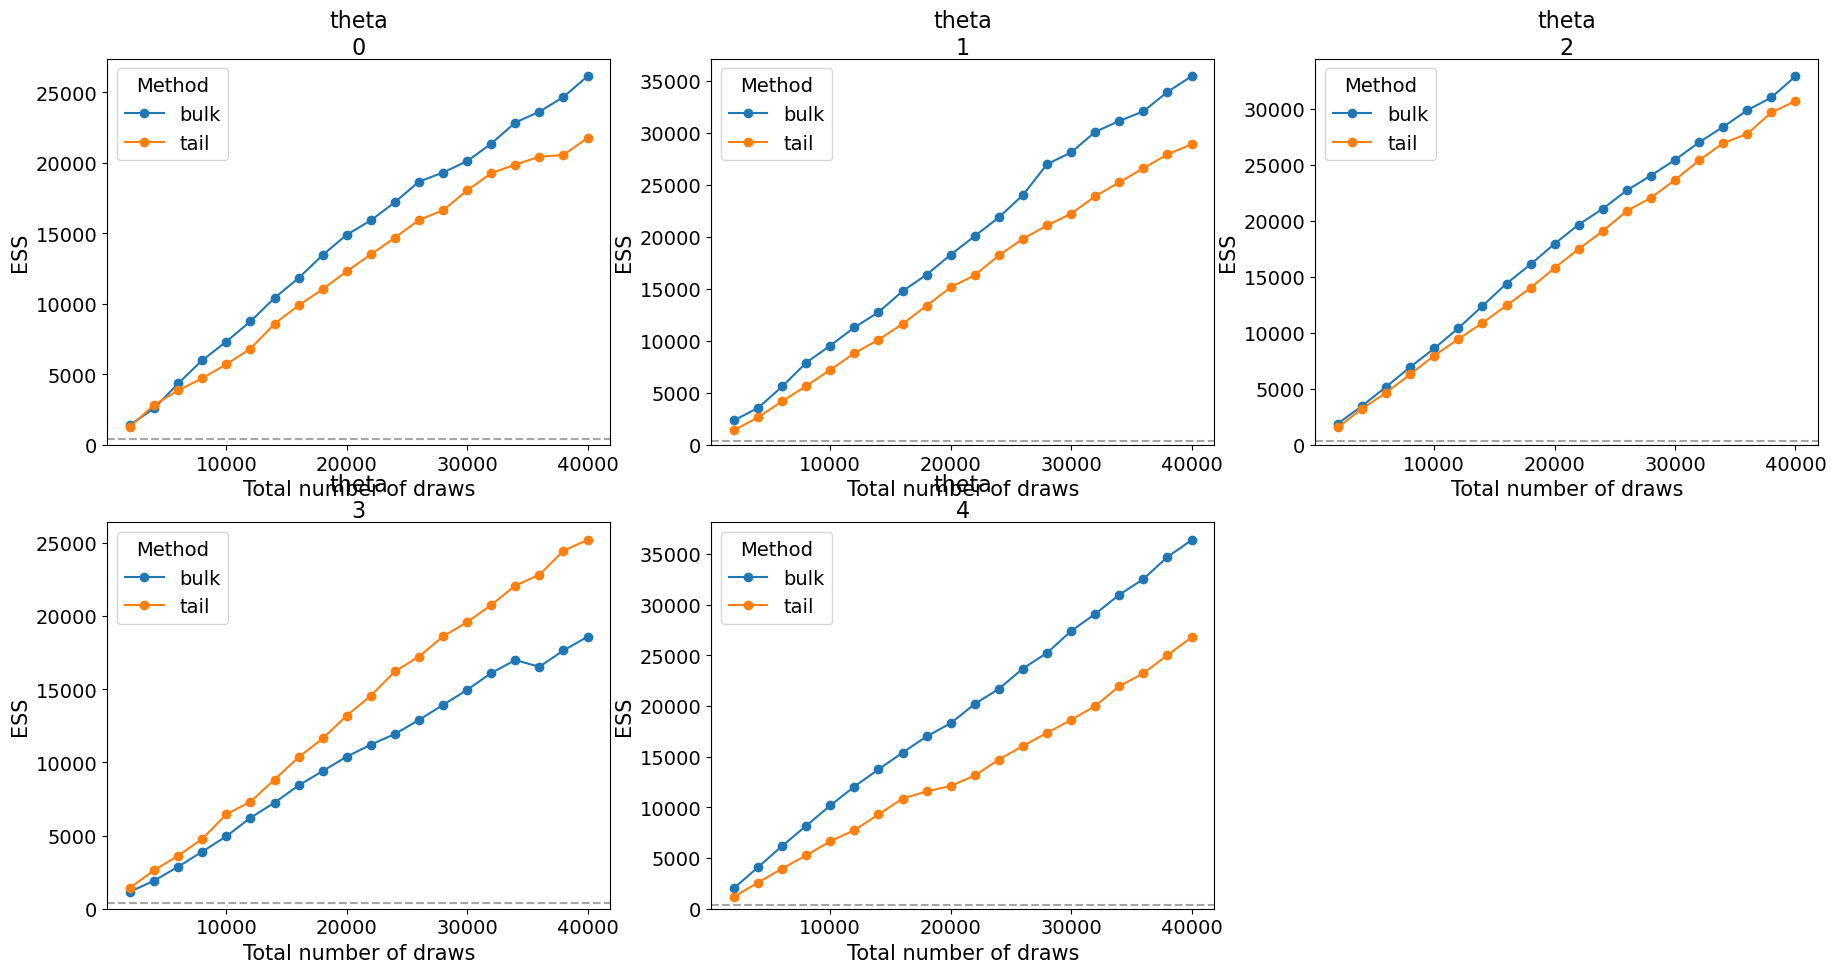

In [36]:
az.plot_ess(
    trace_logreg_h, kind="evolution", var_names=['theta']
)

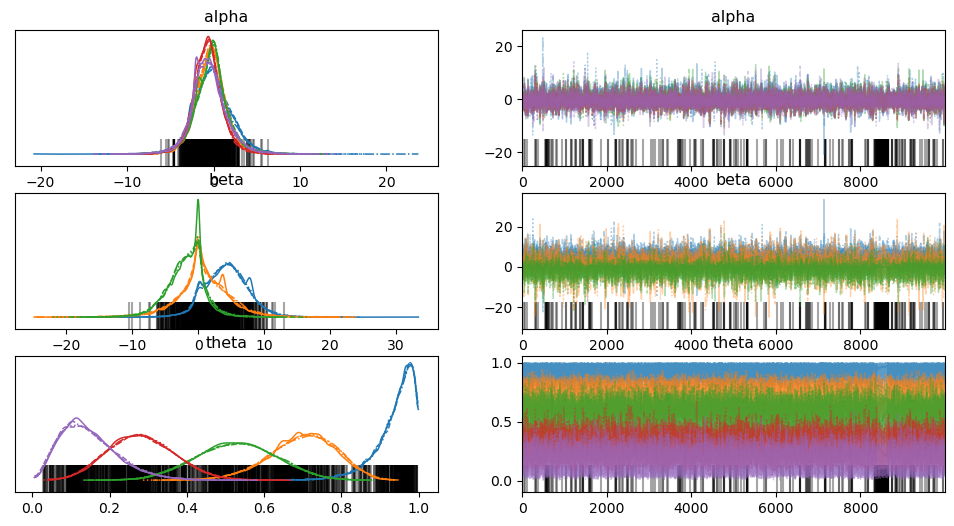

In [37]:
az.plot_trace(trace_logreg_h, var_names=['alpha', 'beta', 'theta']);

In [38]:
stacked_logreg_h = az.extract(trace_logreg_h)

array([0.93830948, 0.70007111, 0.52831761, 0.28268561, 0.14772093])

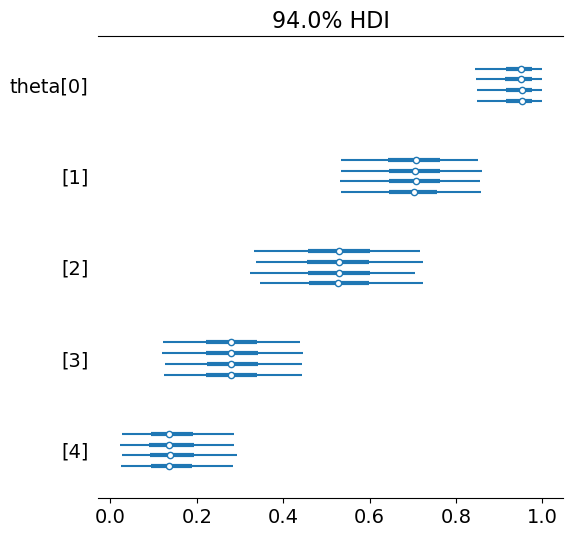

In [39]:
az.plot_forest(trace_logreg_h, var_names='theta')
np.mean(stacked_logreg_h.theta.values, axis=1)

In [40]:
np.mean(stacked_logreg_h.alpha.values, axis=1)

array([-0.09446733, -0.35260479, -0.22491736, -0.68781955, -0.51180556])

In [41]:
np.mean(stacked_logreg_h.beta.values, axis=1)

array([ 4.25876797,  0.68740618, -1.83714098])

#### Non-centered model

Non-centered model should sample better

In [42]:
with pm.Model() as model_logreg_hnc:
    
    # Extract data from dataframe
    K = data.shape[0]
    C = data.shape[1] - 2    
    s_k = pm.ConstantData('s_k', data.values[:, 0:C])
    
    # define the standard normal random variables
    z_α = pm.Normal('z_alpha', mu=0, sigma=1, shape=K) 
    z_β = pm.Normal('z_beta', mu=0, sigma=1, shape=(C,)) 

    # Define hyper-priors
    μ_α = pm.Normal('mu_alpha', mu=0, sigma=10)    
    σ_α = pm.HalfNormal('sigma_alpha', sigma=10)    
    σ_β = pm.HalfNormal('sigma_beta', sigma=10, shape=(C,))  

    # Define priors
    α = pm.Deterministic('alpha', μ_α + (z_α * σ_α))
    β = pm.Deterministic('beta', z_β * σ_β)

    # Define the linear model using dot product 
    p = pm.math.dot(s_k, β) + α
    θ = pm.Deterministic('theta', pm.math.invlogit(p))

    # Define the likelihood
    pm.Binomial('y', n=n, p=θ, observed=data['n_success'], shape=K)

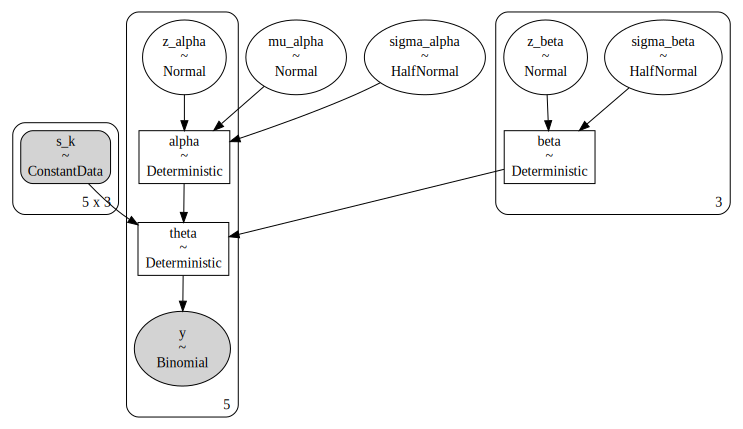

In [43]:
pm.model_to_graphviz(model_logreg_hnc)

In [44]:
with model_logreg_hnc:
    trace_logreg_hnc = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_alpha, z_beta, mu_alpha, sigma_alpha, sigma_beta]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 473 seconds.


In [45]:
az.summary(trace_logreg_hnc).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_alpha[0],0.17,0.97,-1.64,1.99,0.01,0.00,28766.0,28577.0,1.0
z_alpha[1],-0.00,0.79,-1.51,1.51,0.00,0.00,26539.0,25619.0,1.0
z_alpha[2],0.17,0.88,-1.50,1.85,0.00,0.00,27319.0,27257.0,1.0
z_alpha[3],-0.31,0.79,-1.82,1.21,0.00,0.00,21816.0,22536.0,1.0
z_alpha[4],-0.04,0.95,-1.81,1.75,0.00,0.00,32455.0,28709.0,1.0
z_beta[0],0.66,0.62,-0.40,2.04,0.00,0.00,13934.0,13107.0,1.0
z_beta[1],0.12,0.78,-1.43,1.62,0.01,0.00,13426.0,21307.0,1.0
z_beta[2],-0.36,0.68,-1.77,0.96,0.00,0.00,17376.0,19268.0,1.0
mu_alpha,-0.36,1.89,-3.88,3.33,0.02,0.01,9826.0,13573.0,1.0
sigma_alpha,1.06,1.32,0.00,3.22,0.01,0.01,10584.0,17026.0,1.0


array([[<AxesSubplot: title={'center': 'theta\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'theta\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'theta\n2'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'theta\n3'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'theta\n4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: >]], dtype=object)

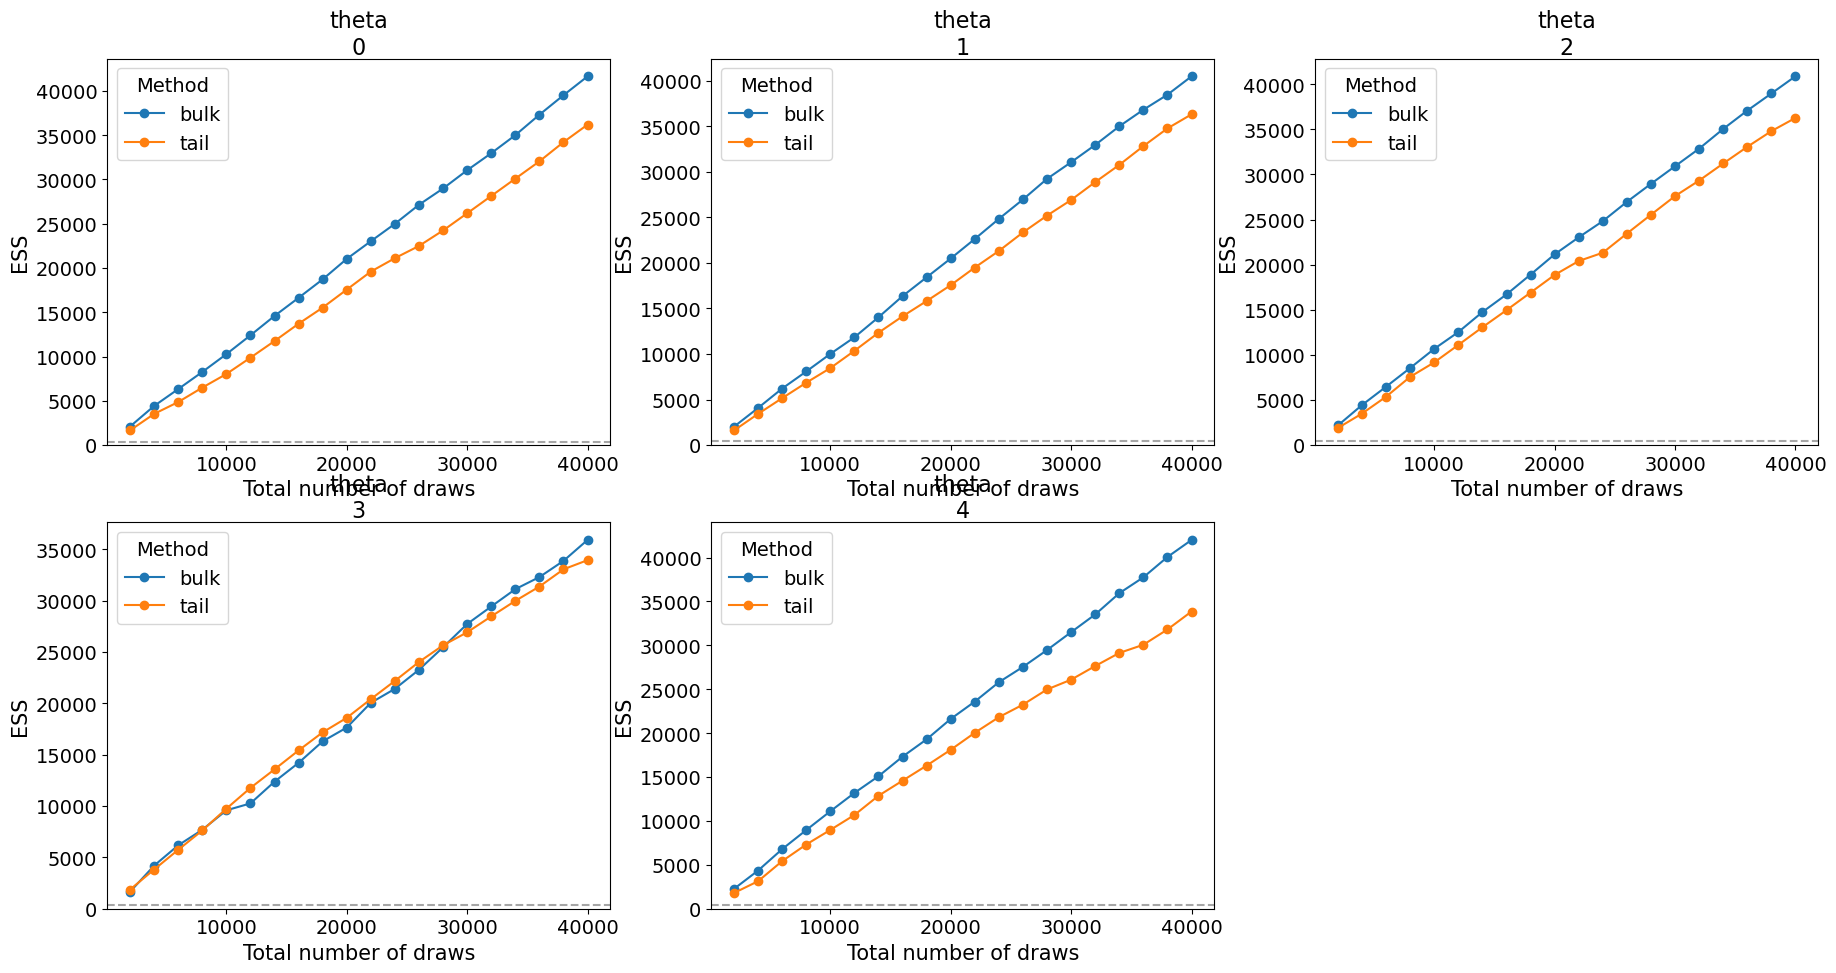

In [46]:
az.plot_ess(
    trace_logreg_hnc, kind="evolution", var_names=['theta']
)

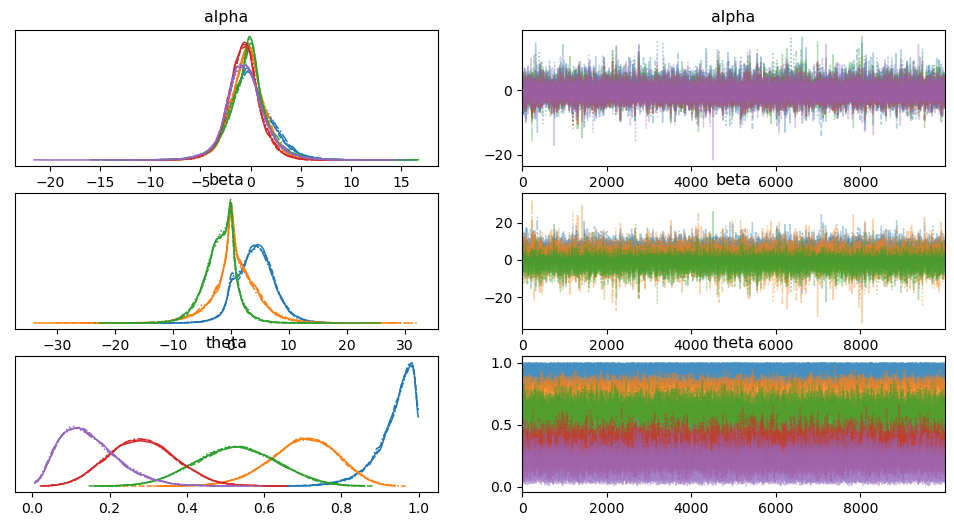

In [47]:
az.plot_trace(trace_logreg_hnc, var_names=['alpha', 'beta', 'theta']);

In [48]:
stacked_logreg_hnc = az.extract(trace_logreg_hnc)

array([0.93849508, 0.7010553 , 0.52780019, 0.28453206, 0.1484128 ])

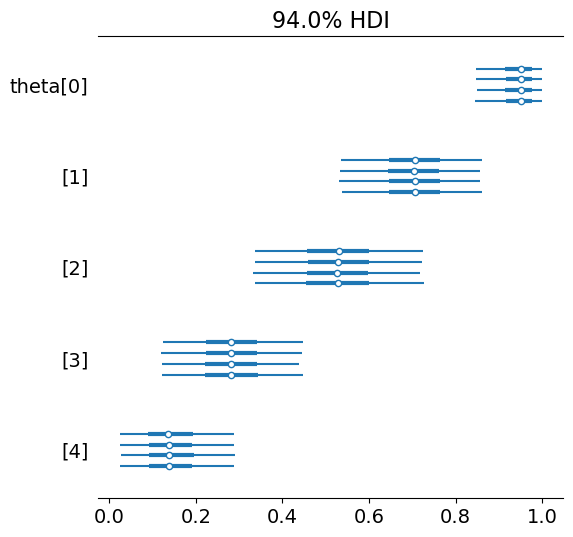

In [49]:
az.plot_forest(trace_logreg_hnc, var_names='theta')
np.mean(stacked_logreg_hnc.theta.values, axis=1)

In [50]:
np.mean(stacked_logreg_hnc.alpha.values, axis=1)

array([-0.05236288, -0.32823192, -0.21882985, -0.67045497, -0.49333989])

In [51]:
np.mean(stacked_logreg_hnc.beta.values, axis=1)

array([ 4.20022244,  0.67124475, -1.85647576])

### Model comparison

Model comparison using Leave-one-out Cross-validation ([LOO](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html))

> LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples (without the need for re-fitting the data). This approximation is based on importance sampling. The importance weights are stabilized using a method known as Pareto-smoothed importance sampling (PSIS).

In [52]:
loo_simple = az.loo(trace_simple)
loo_simple

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 40000 posterior samples and 5 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -15.37     0.98
p_loo        5.90        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         4   80.0%
   (1, Inf)   (very bad)    1   20.0%

In [53]:
loo_logreg = az.loo(trace_logreg)
loo_logreg

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 40000 posterior samples and 5 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -14.08     0.51
p_loo        4.91        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         4   80.0%
   (1, Inf)   (very bad)    1   20.0%

In [55]:
loo_logreg_hnc = az.loo(trace_logreg_hnc)
loo_logreg_hnc

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 40000 posterior samples and 5 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -12.40     0.78
p_loo        3.44        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         5  100.0%
   (1, Inf)   (very bad)    0    0.0%

In [58]:
df_comp_loo = az.compare({
    'simple': trace_simple, 
    'logreg': trace_logreg,
    'logreg_hierarchical': trace_logreg_hnc    
})
df_comp_loo

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/pyBasket/lib/python3.11/site-pac

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
logreg_hierarchical,0,-12.403123,3.437155,0.000000,1.000000e+00,0.782638,0.000000,True,log
logreg,1,-14.082935,4.913730,1.679812,8.326673e-16,0.511570,0.403765,True,log
simple,2,-15.367991,5.900296,2.964869,0.000000e+00,0.983432,1.682071,True,log


Compare models based on their expected log pointwise predictive density ([ELPD](https://python.arviz.org/en/latest/api/generated/arviz.compare.html)).

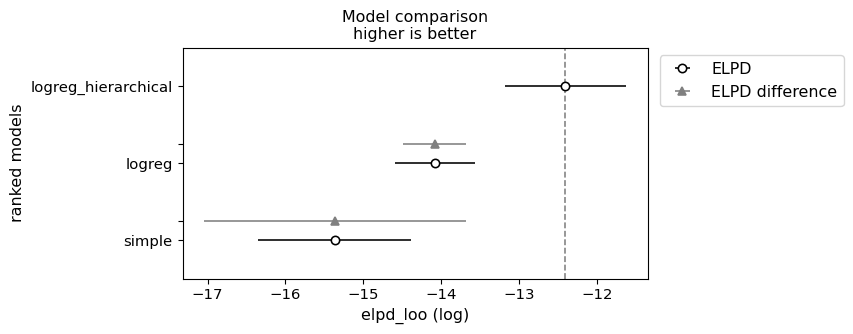

In [59]:
az.plot_compare(df_comp_loo);